# Exploratory data analysis in retinal bipolar data with autoencoders

In this notebook, we will build a neural network that explores the retinal bipolar dataset for Shekhar et al., 2016 without using the manually annotated cell type labels.

## 1. Imports

In [1]:
!pip install --user scprep

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import scprep

## 2. Loading the retinal bipolar data

We'll use the same retinal bipolar data we used for the classifier.

In [0]:
scprep.io.download.download_google_drive("1pRYn62SOmmJxwVU0sSW7eBagRL2RJmx0", "shekhar_data.pkl")
scprep.io.download.download_google_drive("1FlNktWuJCka3pXOvNIFfRitGluZy2ftt", "shekhar_clusters.pkl")

In [0]:
data_raw = pd.read_pickle("shekhar_data.pkl")
clusters = pd.read_pickle("shekhar_clusters.pkl")

In [0]:
data = scprep.reduce.pca(data_raw, n_components=100, method='dense').to_numpy()
labels, cluster_names = pd.factorize(clusters['CELLTYPE'])

## 3. Building an autoencoder

An **autoencoder** is a network that tries to reproduce its input. 

In this case, we will squeeze the data through a two-dimensional bottleneck which we can use for visualization. Also, reducing the dimension from 100 down to 2 forces the network to only retain the most important information, which intrinsically behaves as a kind of denoising.

**Note Dan/Scott/Matt**: Does the term 'bottleneck' have a specific mathematical meaning.  If so that needs to be fleshed out a bit here.  

#### Create layers


In [0]:
class layer(nn.Module):
    def __init__(self, input_size, output_size, activation=None):
        super(layer, self).__init__()

        self.weight = torch.randn(input_size, hidden_size).double().requires_grad_()
        self.bias = torch.randn(hidden_size).double().requires_grad_()
        self.activation = activation

    def forward(self, x):
        output = torch.matmul(x, self.weight) + self.bias
        output = self.activation(output)
        return output


In [0]:
# move data to pytorch tensors
data_tensor = torch.Tensor(data)


### Method 1

In [0]:

# layers will be input -> 100 -> 2 --> 100 -> output
# first hidden layer of size 100
hidden_layer1 = layer(input_size=data_tensor.shape[1], 
                      output_size= 100, 
                      activation=nn.ReLU())

# we won't apply a nonlinear activation to the 2D middle layer
hidden_layer2 = layer(input_size=100, 
                      output_size=2,
                      activation=None)

# last hidden layer of size 100
hidden_layer3 = layer(input_size=2,
                         output_size=100, 
                         activation=nn.ReLU())

# the output should be the same size as the input
output = layer(input_size=100,
              output_size=data_tensor.shape[1], 
               activation=None)


### Method 2

PyTorch provides the linear layers we've been manually defining in it's nn module (the same place we've been getting our activation functions) as 

```
nn.Linear()
```
so let's go ahead and repeat the layer creation step above using this new knowledge.

[link to documentation](https://pytorch.org/docs/stable/nn.html#linear)



In [0]:

# layers will be input -> 100 -> 2 --> 100 -> output

# first hidden layer of size 100
hidden_layer1 = nn.Linear(in_features=data_tensor.shape[1], 
                      out_features= 100)

# second middle layer
hidden_layer2 = nn.Linear(in_features=100, 
                      out_features=2)

# last hidden layer of size 100
hidden_layer3 = nn.Linear(in_features=2,
                        out_features=100)

# the output should be the same size as the input
output_layer4 = nn.Linear(in_features=100,
              out_features=data_tensor.shape[1])

as you may have noticed, we did not specify our activation functions this time. Since this is separate from the nn.Linear class, we will have to define them outside our layers. 

In [0]:
activation_1 = nn.ReLU()
activation_3 = nn.ReLU()

now let's use some PyTorch magic and create a model using nn.Sequential, which we can just treat as some fancy list for Pytorch layers

In [0]:
autoencoder1 = nn.Sequential(hidden_layer1,
                            activation_1,
                            hidden_layer2,
                            hidden_layer3,
                            activation_3,
                            output_layer4
                            )

nn.Sequential ties together our layers and creates a model. The data passes through the model in the order we place the layers. 

lets print out our model

In [61]:
print(autoencoder1)

Sequential(
  (0): Linear(in_features=100, out_features=100, bias=True)
  (1): ReLU()
  (2): Linear(in_features=100, out_features=2, bias=True)
  (3): Linear(in_features=2, out_features=100, bias=True)
  (4): ReLU()
  (5): Linear(in_features=100, out_features=100, bias=True)
)


#### Define Optimizer

In [0]:
learning_rate = 0.001

optimizer = optim.SGD(autoencoder1.parameters(),
                       lr=learning_rate)


#### Loss function

In [0]:
loss_fcn = nn.MSELoss()

#### Batch size

In [0]:
batch_size=100

#### Train the network

Let's move our hyperparameters to a function that we can reuse to train other models

In [0]:
def train_model(model):

  batch_size=100

  learning_rate = 0.001

  optimizer = optim.SGD(model.parameters(),
                        lr=learning_rate)

  loss_fcn = nn.MSELoss()

  # we'll train the network for 10 epochs
  step = 0
  for epoch in range(10):
      # randomize the order of the data each time through
      random_order = np.random.permutation(data_tensor.shape[0])
      data_randomized = data_tensor[random_order]

      # train the network on batches of size `batch_size`
      for data_batch in np.array_split(data_randomized, data_randomized.shape[0] // batch_size):
          step += 1

          # update the network weights to minimize the loss
          output = model(data_batch)

          # get loss
          loss = loss_fcn(output, data_batch)
          
          # print the loss every 100 epochs
          if step % 100 == 0:
              print("Step: {} Loss: {:.3f}".format(step, loss.item()))


          # backpropagate the loss
          loss.backward()

          # update parameters
          optimizer.step()

          # reset gradients
          optimizer.zero_grad()

  return model


In [64]:
autoencoder1 = train_model(autoencoder1)

Step: 100 Loss: 6.474
Step: 200 Loss: 6.371
Step: 300 Loss: 6.606
Step: 400 Loss: 6.251
Step: 500 Loss: 6.437
Step: 600 Loss: 6.354
Step: 700 Loss: 6.394
Step: 800 Loss: 6.689
Step: 900 Loss: 6.234
Step: 1000 Loss: 6.831
Step: 1100 Loss: 6.926
Step: 1200 Loss: 6.636
Step: 1300 Loss: 6.528
Step: 1400 Loss: 6.225
Step: 1500 Loss: 7.025
Step: 1600 Loss: 6.634
Step: 1700 Loss: 6.363
Step: 1800 Loss: 6.565


#### Visualize the output

Rather than evaluating our model with our data like we did with the classifier, we can now use our model to evaluate our data (aka exploratory data analysis)!  Autoencoder networks are very useful in exploratory data analysis.

In [65]:
print(autoencoder1[:3])

Sequential(
  (0): Linear(in_features=100, out_features=100, bias=True)
  (1): ReLU()
  (2): Linear(in_features=100, out_features=2, bias=True)
)


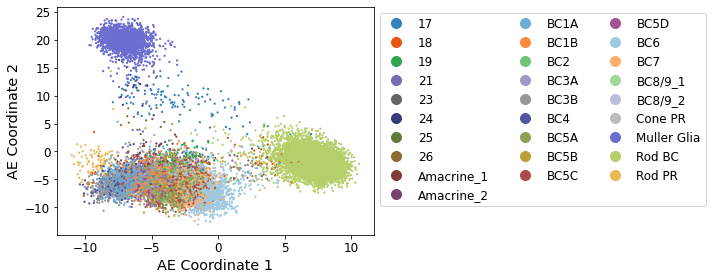

In [66]:
# let's get the 2D internal hidden layer and visualize it with a scatter plot

with torch.no_grad():
  ae_coordinates = autoencoder[:3](data_tensor)


scprep.plot.scatter2d(ae_coordinates.numpy(), c=cluster_names[labels],
                      label_prefix='AE Coordinate ', discrete=True,
                      legend_anchor=(1,1), figsize=(10,4))

### Discussion

What do you notice about the visualization? How does this compare to the visualizations you have seen with PCA, t-SNE, UMAP and PHATE?

#### _Breakpoint_  - once you get here, please help those around you!

## Exercise 4 - Activation functions on the visualization layer

Notice we did not use an acitvation function for the hidden layer we were going to visualize.

Repeat the process with other activation functions like `nn.ReLU`, `nn.Sigmoid`, `nn.Tanh`, etc. You can see more in the [PyTorch activation function documentions](https://pytorch.org/docs/stable/nn.html#non-linear-activations-weighted-sum-nonlinearity). 

Note how the visualization changes. Has the data changed at all?

In [0]:
# activation_1 = 
# activation_2 = 

# autoencoder2 = nn.Sequential(hidden_layer1,
#                             activation_1,
#                             hidden_layer2,
#                             hidden_layer3,
#                             activation_3,
#                             output_layer4
#                             )

In [0]:
# autoencoder2 = train_model(autoencoder2)

In [0]:
# let's get the 2D internal hidden layer and visualize it with a scatter plot

with torch.no_grad():
  ae_coordinates2 = autoencoder2[:3](data_tensor)

scprep.plot.scatter2d(ae_coordinates2, c=cluster_names[labels],
                      label_prefix='AE Coordinate ', discrete=True,
                      legend_anchor=(1,1), figsize=(10,4))

#### _Breakpoint_  - once you get here, please help those around you!

## Exercise 5 - Activation functions on the wide hidden layers

Now turn the activation for the visualization layer back to None, but experiment with the activation function for the 100-dimensional layers.

Is there a change? Why?

In [0]:

# Copy the code for defining our model from above but this time remove the activation function
# for the middle layer and switch out the activation functions for layer 1 and 3
# ===================




In [0]:
# let's get the 2D internal hidden layer and visualize it with a scatter plot

with torch.no_grad():
  ae_coordinates3 = autoencoder3[:3](data_tensor)

scprep.plot.scatter2d(ae_coordinates3, c=cluster_names[labels],
                      label_prefix='AE Coordinate ', discrete=True,
                      legend_anchor=(1,1), figsize=(10,4))